#Fine-tuning Transformers (BERT)




##Installing and Importing Libraries

In [0]:
USE_BUCKET = True #@param {type:"boolean"}

if USE_BUCKET:
  from google.colab import auth
  auth.authenticate_user()

In [0]:
!rm -r outputs_*

In [0]:
!pip install pytorch_transformers
!pip install tensorboardX
!gsutil cp gs://qatar_competition/utils.py ./

     |████████████████████████████████| 184kB 2.7MB/s 
     |████████████████████████████████| 860kB 39.8MB/s 
     |████████████████████████████████| 655kB 36.7MB/s 
     |████████████████████████████████| 1.0MB 41.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.34-cp36-none-any.whl size=883992 sha256=05c6a86bb4d8eb1a095617bc8cee211d31a84fdb8ab2c5ddfee846f7e5da52b7
  Stored in directory: /root/.cache/pip/wheels/07/b9/5b/8bd674c23e962fbff34420a9fa7a2c374d591ecadd5bc37684
  Created wheel for regex: filename=regex-2019.8.19-cp36-cp36m-linux_x86_64.whl size=609224 sha256=90b4c8aba19174729c9c1d084c3a475e144a91be337dc188eaeacaed8c115855
  Stored in directory: /root/.cache/pip/wheels/90/04/07/b5010fb816721eb3d6dd64ed5cc8111ca23f97fdab8619b5be
Successfully built sacremoses regex
     |████████████████████████████████| 225kB 2.9MB/s 
Copying gs://qatar_competition/utils.py...
- [1 files][ 13.3 KiB/ 13.3 KiB]                                                
Operation completed ove

In [0]:
!mkdir data
!gsutil cp -r gs://qatar_competition/data ./

In [0]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

Writing setup.sh


In [0]:
!sh setup.sh

In [0]:
from __future__ import absolute_import, division, print_function

import glob
import logging
import os
import random
import json

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm_notebook, trange
from tensorboardX import SummaryWriter


from pytorch_transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)

from pytorch_transformers import AdamW, WarmupLinearSchedule

from utils import (convert_examples_to_features,
                        output_modes, processors)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

##Initializing Arguments

In [0]:
args = {
    'data_dir': 'data/',
    'model_type':  'bert',
    'model_name': 'bert-base-cased',
    'task_name': 'binary',
    'output_dir': 'outputs_bert/',
    'cache_dir': 'cache/',
    'do_train': True,
    'do_eval': True,
    'fp16': True,
    'fp16_opt_level': 'O1',
    'max_seq_length': 128,
    'output_mode': 'classification',
    'train_batch_size': 8,
    'eval_batch_size': 8,
    'gradient_accumulation_steps': 1,
    'num_train_epochs': 10,
    'weight_decay': 0,
    'learning_rate': 2e-5,
    'adam_epsilon': 1e-8,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 20,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': False,
    'reprocess_input_data': True,
    'notes': 'Using Qatar Fake News dataset'
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
args

{'adam_epsilon': 1e-08,
 'cache_dir': 'cache/',
 'data_dir': 'data/',
 'do_eval': True,
 'do_train': True,
 'eval_all_checkpoints': True,
 'eval_batch_size': 8,
 'evaluate_during_training': False,
 'fp16': True,
 'fp16_opt_level': 'O1',
 'gradient_accumulation_steps': 1,
 'learning_rate': 2e-05,
 'logging_steps': 50,
 'max_grad_norm': 1.0,
 'max_seq_length': 128,
 'model_name': '\tbert-base-cased',
 'model_type': 'bert',
 'notes': 'Using Qatar Fake News dataset',
 'num_train_epochs': 10,
 'output_dir': 'outputs_bert/',
 'output_mode': 'classification',
 'overwrite_output_dir': False,
 'reprocess_input_data': True,
 'save_steps': 20,
 'task_name': 'binary',
 'train_batch_size': 8,
 'warmup_steps': 0,
 'weight_decay': 0}

In [0]:
with open('args.json', 'w') as f:
    json.dump(args, f)

In [0]:
if os.path.exists(args['output_dir']) and os.listdir(args['output_dir']) and args['do_train'] and not args['overwrite_output_dir']:
    raise ValueError("Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(args['output_dir']))

In [0]:
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer),
    'xlnet': (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

##Importing Models

In [0]:
config = config_class.from_pretrained(args['model_name'], num_labels=2, finetuning_task=args['task_name'])
tokenizer = tokenizer_class.from_pretrained(args['model_name'])

INFO:pytorch_transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json not found in cache or force_download set to True, downloading to /tmp/tmpzed5bmwp
100%|██████████| 313/313 [00:00<00:00, 178057.39B/s]
INFO:pytorch_transformers.file_utils:copying /tmp/tmpzed5bmwp to cache at /root/.cache/torch/pytorch_transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.d7a3af18ce3a2ab7c0f48f04dc8daff45ed9a3ed333b9e9a79d012a0dedf87a6
INFO:pytorch_transformers.file_utils:creating metadata file for /root/.cache/torch/pytorch_transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.d7a3af18ce3a2ab7c0f48f04dc8daff45ed9a3ed333b9e9a79d012a0dedf87a6
INFO:pytorch_transformers.file_utils:removing temp file /tmp/tmpzed5bmwp
INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /root/.cache/torch/pytorch_transfor

In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
model = model_class.from_pretrained(args['model_name'])

INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /root/.cache/torch/pytorch_transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.d7a3af18ce3a2ab7c0f48f04dc8daff45ed9a3ed333b9e9a79d012a0dedf87a6
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-pytorch_model

In [0]:
model.to(device);

In [0]:
task = args['task_name']

if task in processors.keys() and task in output_modes.keys():
    processor = processors[task]()
    label_list = processor.get_labels()
    num_labels = len(label_list)
else:
    raise KeyError(f'{task} not found in processors or in output_modes. Please check utils.py.')

##Defining Utility Functions

In [0]:
def load_and_cache_examples(task, tokenizer, mode="train"):
    processor = processors[task]()
    output_mode = args['output_mode']
    
    #mode = 'dev' if evaluate else 'train'
    cached_features_file = os.path.join(args['data_dir'], f"cached_{mode}_{args['model_name']}_{args['max_seq_length']}_{task}")
    
    if os.path.exists(cached_features_file) and not args['reprocess_input_data']:
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
               
    else:
        logger.info("Creating features from dataset file at %s", args['data_dir'])
        label_list = processor.get_labels()
        if mode=="train":
          examples=processor.get_train_examples(args['data_dir']);
        if mode=="dev":
          examples=processor.get_dev_examples(args['data_dir']);
        if mode=="predict":
          examples=processor.get_predict_examples(args['data_dir'])
        #examples = processor.get_dev_examples(args['data_dir']) if evaluate else processor.get_train_examples(args['data_dir'])
        
        if __name__ == "__main__":
            features = convert_examples_to_features(examples, label_list, args['max_seq_length'], tokenizer, output_mode,
                cls_token_at_end=bool(args['model_type'] in ['xlnet']),            # xlnet has a cls token at the end
                cls_token=tokenizer.cls_token,
                cls_token_segment_id=2 if args['model_type'] in ['xlnet'] else 0,
                sep_token=tokenizer.sep_token,
                sep_token_extra=bool(args['model_type'] in ['roberta']),           # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                pad_on_left=bool(args['model_type'] in ['xlnet']),                 # pad on the left for xlnet
                pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                pad_token_segment_id=4 if args['model_type'] in ['xlnet'] else 0)
        
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)
        
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    return dataset

In [0]:
def train(train_dataset, model, tokenizer):
    tb_writer = SummaryWriter()
    
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args['train_batch_size'])
    
    t_total = len(train_dataloader) // args['gradient_accumulation_steps'] * args['num_train_epochs']
    
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args['weight_decay']},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'], eps=args['adam_epsilon'])
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=args['warmup_steps'], t_total=t_total)
    
    if args['fp16']:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args['fp16_opt_level'])
        
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args['num_train_epochs'])
    logger.info("  Total train batch size  = %d", args['train_batch_size'])
    logger.info("  Gradient Accumulation steps = %d", args['gradient_accumulation_steps'])
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(int(args['num_train_epochs']), desc="Epoch")
    
    for _ in train_iterator:
        epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
            print("\r%f" % loss, end='')

            if args['gradient_accumulation_steps'] > 1:
                loss = loss / args['gradient_accumulation_steps']

            if args['fp16']:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args['max_grad_norm'])
                
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])

            tr_loss += loss.item()
            if (step + 1) % args['gradient_accumulation_steps'] == 0:
                scheduler.step()  # Update learning rate schedule
                optimizer.step()
                model.zero_grad()
                global_step += 1

                if args['logging_steps'] > 0 and global_step % args['logging_steps'] == 0:
                    # Log metrics
                    if args['evaluate_during_training']:  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar('eval_{}'.format(key), value, global_step)
                    tb_writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar('loss', (tr_loss - logging_loss)/args['logging_steps'], global_step)
                    logging_loss = tr_loss

                if args['save_steps'] > 0 and global_step % args['save_steps'] == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args['output_dir'], 'checkpoint-{}'.format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    logger.info("Saving model checkpoint to %s", output_dir)


    return global_step, tr_loss / global_step

In [0]:
from sklearn.metrics import mean_squared_error, matthews_corrcoef, confusion_matrix
from scipy.stats import pearsonr

def get_mismatched(labels, preds):
    mismatched = labels != preds
    examples = processor.get_dev_examples(args['data_dir'])
    wrong = [i for (i, v) in zip(examples, mismatched) if v]
    
    return wrong

def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }, get_mismatched(labels, preds)

def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def evaluate(model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args['output_dir']

    results = {}
    EVAL_TASK = args['task_name']

    eval_dataset = load_and_cache_examples(EVAL_TASK, tokenizer, mode="dev")
    if not os.path.exists(eval_output_dir):
        os.makedirs(eval_output_dir)


    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args['eval_batch_size'])

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args['eval_batch_size'])
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    if args['output_mode'] == "classification":
        preds = np.argmax(preds, axis=1)
    elif args['output_mode'] == "regression":
        preds = np.squeeze(preds)
    result, wrong = compute_metrics(EVAL_TASK, preds, out_label_ids)
    results.update(result)

    output_eval_file = os.path.join(eval_output_dir, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return results, wrong

In [0]:
def predict(model, tokenizer, prefix=""):
  pred_output_dir = args['output_dir']
  
  results={}
  PRED_TASK = args['task_name']
  
  pred_dataset = load_and_cache_examples(PRED_TASK, tokenizer, mode='predict')
  if not os.path.exists(pred_output_dir):
    os.makedirs(pred_output_dir)
    
  
  pred_sampler = SequentialSampler(pred_dataset)
  pred_dataloader = DataLoader(pred_dataset, sampler=pred_sampler, batch_size=args['eval_batch_size'])
  
  # Eval!
  logger.info("***** Running prediction {} *****".format(prefix))
  logger.info("  Num examples = %d", len(pred_dataset))
  logger.info("  Batch size = %d", args['eval_batch_size'])
  
  preds = None
  for batch in pred_dataloader:
    with torch.no_grad():
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids': batch[0],'attention_mask': batch[1],'token_type_ids': batch[2],'labels': batch[3]}
      
      outputs = model(**inputs)
      _, logits = outputs[:2]
    if preds is None:
        preds = logits.detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)

  preds = np.argmax(preds, axis=1)
      
  return preds

##Training

In [0]:
if args['do_train']:
    train_dataset = load_and_cache_examples(task, tokenizer , mode="train")
    global_step, tr_loss = train(train_dataset, model, tokenizer)
    logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

INFO:__main__:Creating features from dataset file at data/
100%|██████████| 384/384 [00:00<00:00, 569.13it/s]
INFO:__main__:Saving features into cached file data/cached_train_bert-base-cased_128_binary
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 384
INFO:__main__:  Num Epochs = 10
INFO:__main__:  Total train batch size  = 8
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 480
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


0.742526

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-20


0.633434

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-40


0.652607

Epoch:  10%|█         | 1/10 [00:08<01:16,  8.45s/it]

0.687240Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
0.659005

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-60


0.518731

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-80


0.486999Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
0.480121

Epoch:  20%|██        | 2/10 [00:16<01:07,  8.41s/it]

0.262655

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-100


0.325766

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-120


0.398997

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-140


0.214992

Epoch:  30%|███       | 3/10 [00:26<01:01,  8.77s/it]

0.333924

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-160


0.141506

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-180


0.418911

Epoch:  40%|████      | 4/10 [00:34<00:52,  8.72s/it]

0.197477

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-200


0.052860

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-220


0.187335Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
0.017957

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-240
Epoch:  50%|█████     | 5/10 [00:44<00:45,  9.11s/it]

0.053400

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-260


0.198101Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
0.029215

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-280


0.043244

Epoch:  60%|██████    | 6/10 [00:53<00:35,  8.98s/it]

0.005501

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-300


0.014035

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-320


0.003030

Epoch:  70%|███████   | 7/10 [01:02<00:26,  8.86s/it]

0.005672

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-340


0.003725

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-360


0.003828

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-380


0.002494

Epoch:  80%|████████  | 8/10 [01:11<00:18,  9.04s/it]

0.003047

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-400


0.016200

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-420


0.003030

Epoch:  90%|█████████ | 9/10 [01:20<00:08,  8.84s/it]

0.002930

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-440


0.002623

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-460


0.002541

INFO:__main__:Saving model checkpoint to outputs_bert/checkpoint-480
Epoch: 100%|██████████| 10/10 [01:29<00:00,  9.07s/it]
INFO:__main__: global_step = 480, average loss = 0.22688347741495818


In [0]:
import torch
torch.cuda.empty_cache()

In [0]:
if args['do_train']:
    if not os.path.exists(args['output_dir']):
            os.makedirs(args['output_dir'])
    logger.info("Saving model checkpoint to %s", args['output_dir'])
    
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(args['output_dir'])
    tokenizer.save_pretrained(args['output_dir'])
    torch.save(args, os.path.join(args['output_dir'], 'training_args.bin'))

INFO:__main__:Saving model checkpoint to outputs_roberta/


##Evaluating

In [0]:
results = {}
if args['do_eval']:
    checkpoints = [args['output_dir']]
    if args['eval_all_checkpoints']:
        checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
        logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    logger.info("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in sorted(checkpoints,reverse = True):
        print(checkpoint)
        global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
        model = model_class.from_pretrained(checkpoint)
        model.to(device)
        with torch.no_grad():
          result, wrong_preds = evaluate(model, tokenizer, prefix=global_step)
          result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
          results.update(result)
        del model
        torch.cuda.empty_cache()

INFO:__main__:Evaluate the following checkpoints: ['outputs_roberta/checkpoint-100', 'outputs_roberta/checkpoint-120', 'outputs_roberta/checkpoint-140', 'outputs_roberta/checkpoint-160', 'outputs_roberta/checkpoint-180', 'outputs_roberta/checkpoint-20', 'outputs_roberta/checkpoint-200', 'outputs_roberta/checkpoint-220', 'outputs_roberta/checkpoint-240', 'outputs_roberta/checkpoint-260', 'outputs_roberta/checkpoint-280', 'outputs_roberta/checkpoint-300', 'outputs_roberta/checkpoint-320', 'outputs_roberta/checkpoint-340', 'outputs_roberta/checkpoint-360', 'outputs_roberta/checkpoint-380', 'outputs_roberta/checkpoint-40', 'outputs_roberta/checkpoint-400', 'outputs_roberta/checkpoint-420', 'outputs_roberta/checkpoint-440', 'outputs_roberta/checkpoint-460', 'outputs_roberta/checkpoint-480', 'outputs_roberta/checkpoint-60', 'outputs_roberta/checkpoint-80', 'outputs_roberta']


outputs_roberta/checkpoint-80


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 207.24it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 80 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 80 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 3
INFO:__main__:  mcc = 0.8819171036881969
INFO:__main__:  tn = 21
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-60


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 151.04it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 60 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 60 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 4
INFO:__main__:  mcc = 0.7979249985750353
INFO:__main__:  tn = 20
INFO:__main__:  tp = 23



outputs_roberta/checkpoint-480


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 158.76it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 480 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 480 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.9198662110077999
INFO:__main__:  tn = 22
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-460


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 246.36it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 460 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 460 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.9198662110077999
INFO:__main__:  tn = 22
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-440


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 155.05it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 440 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 440 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.9198662110077999
INFO:__main__:  tn = 22
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-420


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 249.83it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 420 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 420 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.9198662110077999
INFO:__main__:  tn = 22
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-400


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 165.36it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 400 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 400 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.9198662110077999
INFO:__main__:  tn = 22
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-40


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 157.22it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 40 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 40 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 6
INFO:__main__:  mcc = 0.7242243488319186
INFO:__main__:  tn = 18
INFO:__main__:  tp = 23



outputs_roberta/checkpoint-380


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 224.89it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 380 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 380 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 3
INFO:__main__:  mcc = 0.8819171036881969
INFO:__main__:  tn = 21
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-360


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 154.98it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 360 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 360 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 3
INFO:__main__:  mcc = 0.8819171036881969
INFO:__main__:  tn = 21
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-340


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 228.97it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 340 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 340 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 3
INFO:__main__:  mcc = 0.8819171036881969
INFO:__main__:  tn = 21
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-320


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 131.74it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 320 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 320 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 3
INFO:__main__:  mcc = 0.8819171036881969
INFO:__main__:  tn = 21
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-300


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 176.29it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 300 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 300 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 4
INFO:__main__:  mcc = 0.8451542547285166
INFO:__main__:  tn = 20
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-280


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 255.27it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 280 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 280 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 3
INFO:__main__:  mcc = 0.8819171036881969
INFO:__main__:  tn = 21
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-260


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 164.25it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 260 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 260 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 5
INFO:__main__:  mcc = 0.8094272134003795
INFO:__main__:  tn = 19
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-240


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 166.81it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 240 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 240 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.9198662110077999
INFO:__main__:  tn = 22
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-220


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 93.31it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 220 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 220 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 4
INFO:__main__:  mcc = 0.8451542547285166
INFO:__main__:  tn = 20
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-200


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 164.00it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 200 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 200 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.8757605390397141
INFO:__main__:  tn = 22
INFO:__main__:  tp = 23



outputs_roberta/checkpoint-20


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 245.78it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 20 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


RuntimeError: ignored

AttributeError: ignored

In [0]:
len(results)/5

25.0

In [0]:
def get_result_from_results(resutls,step="outputs"):
  fn = results["fn_"+str(step)]
  fp = results["fp_"+str(step)]
  mcc = results["mcc_"+str(step)]
  tn = results["tn_"+str(step)]
  tp = results["tp_"+str(step)]  
  return {"fn":fn,"fp":fp,"mcc":mcc,"tn":tn,"tp":tp}

def get_metrics(res):
  precision = res["tp"]/(res["fp"]+res["tp"])
  recall = res["tp"]/(res["fn"]+res["tp"])
  accuracy = (res["tp"]+res["tn"])/(res["fn"]+res["tp"]+res["tn"]+res["fp"])
  specificity = res["tn"]/(res["tn"]+res["fp"])
  f1 = (2*precision*recall)/(precision+recall)
  return precision,recall,accuracy,specificity,f1

In [0]:
res = get_result_from_results(results,"10")

In [0]:
precision,recall,accuracy,specificity,f1 = get_metrics(res)

print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("Accuracy: "+str(accuracy))
print("Specificity: "+str(specificity))
print("F1: "+str(f1))

Precision: 1.0
Recall: 1.0
Accuracy: 1.0
Specificity: 1.0
F1: 1.0


In [0]:
p=[]
r=[]
a=[]
s=[]
f=[]
for i in range(20,1+int(348*args["num_train_epochs"]/args["train_batch_size"]),args["save_steps"]):
  try:
    res = get_result_from_results(results,i)
    precision,recall,accuracy,specificity,f1 = get_metrics(res)
    p.append(precision)
    r.append(recall)
    a.append(accuracy)
    s.append(specificity)
    f.append(f1)
  except:
    print("can't find checkpoint: "+str(i))

can't find checkpoint: 20
can't find checkpoint: 100
can't find checkpoint: 120
can't find checkpoint: 140
can't find checkpoint: 160
can't find checkpoint: 180


In [0]:
tt=[20,100,120,140,160,180]
for i in tt:
  try:
    res = get_result_from_results(results,i)
    precision,recall,accuracy,specificity,f1 = get_metrics(res)
    p.append(precision)
    r.append(recall)
    a.append(accuracy)
    s.append(specificity)
    f.append(f1)
  except:
    print("can't find checkpoint: "+str(i))

can't find checkpoint: 20
can't find checkpoint: 100
can't find checkpoint: 120
can't find checkpoint: 140
can't find checkpoint: 160
can't find checkpoint: 180


In [0]:
get_result_from_results(results,20)

KeyError: ignored

In [0]:
res = get_result_from_results(results,"outputs")
precision,recall,accuracy,specificity,f1 = get_metrics(res)
p.append(precision)
r.append(recall)
a.append(accuracy)
s.append(specificity)
f.append(f1)

KeyError: ignored

In [0]:
p

[0.5111111111111111,
 0.6666666666666666,
 0.631578947368421,
 0.9333333333333333,
 1.0,
 0.8636363636363636,
 0.9411764705882353,
 1.0,
 0.7692307692307693,
 1.0,
 1.0,
 0.7407407407407407,
 0.8571428571428571,
 0.8181818181818182,
 1.0,
 1.0,
 0.9473684210526315,
 1.0,
 1.0,
 1.0,
 0.9411764705882353]

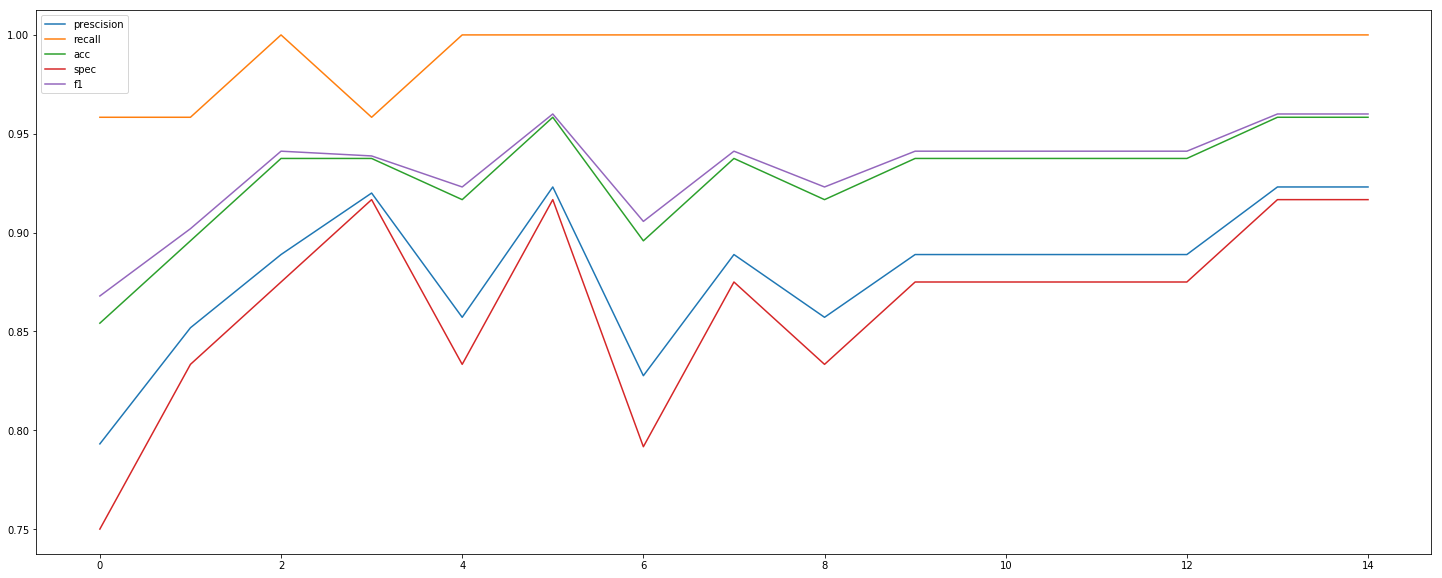

In [0]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [25, 10]
#x= range(10,1+int(348*args["num_train_epochs"]/args["train_batch_size"]),args["save_steps"])

plt.plot(p,label="prescision")
plt.plot(r,label="recall")
plt.plot(a,label="acc")
plt.plot(s,label="spec")
plt.plot(f,label="f1")
plt.legend()
plt.show()


In [0]:
!cp ./data/dev.tsv

##Predictions

In [0]:
checkpoints = [args['output_dir']]
if args['eval_all_checkpoints']:
    checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
    logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
logger.info("Evaluate the following checkpoints: %s", checkpoints)
for checkpoint in checkpoints:
    global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
    model = model_class.from_pretrained(checkpoint)
    model.to(device)
    preds = predict(model, tokenizer, prefix=global_step)

In [0]:
print(preds)

In [0]:
for checkpoint in checkpoints:
  global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
  model = model_class.from_pretrained(checkpoint)
  model.to(device)
  result, wrong_preds = evaluate(model, tokenizer, prefix=global_step)
  result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
  results.update(result)


In [0]:
!gsutil -m cp -r ./outputs_bert gs://qatar_competition/outputs_bert_base_cased_english_10epochs/

In [0]:
!mv ./data/train.tsv ./data/temp.tsv
!mv ./data/dev.tsv ./data/train.tsv
!mv ./data/temp.tsv ./data/dev.tsv

#Fine-tuning Transformers (RoBERTa)




##Installing and Importing Libraries

In [0]:
USE_BUCKET = True #@param {type:"boolean"}

if USE_BUCKET:
  from google.colab import auth
  auth.authenticate_user()

In [0]:
!rm -r outputs_*

In [0]:
!pip install pytorch_transformers
!pip install tensorboardX
!gsutil cp gs://qatar_competition/utils.py ./

     |████████████████████████████████| 184kB 4.8MB/s 
     |████████████████████████████████| 860kB 49.7MB/s 
     |████████████████████████████████| 645kB 45.4MB/s 
     |████████████████████████████████| 1.0MB 45.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=54a2537bbe38cace911c36aa59a4beb24ee9c6c46905beec542a7d416ffb8161
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built sacremoses
     |████████████████████████████████| 194kB 4.7MB/s 
Copying gs://qatar_competition/utils.py...
/ [1 files][ 13.3 KiB/ 13.3 KiB]                                                
Operation completed over 1 objects/13.3 KiB.                                     


In [0]:
!mkdir data
!gsutil cp -r gs://qatar_competition/data ./

Copying gs://qatar_competition/data/all_test.csv...
Copying gs://qatar_competition/data/all_test.tsv...
Copying gs://qatar_competition/data/all_test_clean.csv...
- [3 files][107.0 KiB/107.0 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://qatar_competition/data/all_test_clean.tsv...
Copying gs://qatar_competition/data/all_training.csv...
Copying gs://qatar_competition/data/all_training.tsv...
Copying gs://qatar_competition/data/all_training_clean.csv...
Copying gs://qatar_competition/data/all_training_clean.tsv...
Copying gs://qatar_competition/data/dev.tsv...
Copying gs://qatar_competition/data/fake_test.csv...
Copying gs://qatar_competition/data/fake_training.csv...
Copying gs://qatar_competition/data/legit_test.csv...


In [0]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

Writing setup.sh


In [0]:
!sh setup.sh

Cloning into 'apex'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 5561 (delta 7), reused 8 (delta 3), pack-reused 5531
Receiving objects: 100% (5561/5561), 13.36 MiB | 16.46 MiB/s, done.
Resolving deltas: 100% (3587/3587), done.
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-pgc5wx2m
Created temporary directory: /tmp/pip-req-tracker-o4g9n9wy
Created requirements tracker '/tmp/pip-req-tracker-o4g9n9wy'
Created temporary directory: /tmp/pip-install-8g3jhvlz
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-762zzwkj
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-o4g9n9wy'
    Running setup.py (

In [0]:
from __future__ import absolute_import, division, print_function

import glob
import logging
import os
import random
import json

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm_notebook, trange
from tensorboardX import SummaryWriter


from pytorch_transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)

from pytorch_transformers import AdamW, WarmupLinearSchedule

from utils import (convert_examples_to_features,
                        output_modes, processors)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

##Initializing Arguments

In [0]:
args = {
    'data_dir': 'data/',
    'model_type':  'roberta',
    'model_name': 'roberta-base',
    'task_name': 'binary',
    'output_dir': 'outputs_roberta/',
    'cache_dir': 'cache/',
    'do_train': True,
    'do_eval': True,
    'fp16': False,
    'fp16_opt_level': 'O1',
    'max_seq_length': 128,
    'output_mode': 'classification',
    'train_batch_size': 8,
    'eval_batch_size': 8,
    'gradient_accumulation_steps': 1,
    'num_train_epochs': 10,
    'weight_decay': 0,
    'learning_rate': 2e-5,
    'adam_epsilon': 1e-8,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 20,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': False,
    'reprocess_input_data': True,
    'notes': 'Using Qatar Fake News dataset'
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
args

{'adam_epsilon': 1e-08,
 'cache_dir': 'cache/',
 'data_dir': 'data/',
 'do_eval': True,
 'do_train': True,
 'eval_all_checkpoints': True,
 'eval_batch_size': 8,
 'evaluate_during_training': False,
 'fp16': False,
 'fp16_opt_level': 'O1',
 'gradient_accumulation_steps': 1,
 'learning_rate': 2e-05,
 'logging_steps': 50,
 'max_grad_norm': 1.0,
 'max_seq_length': 128,
 'model_name': 'roberta-base',
 'model_type': 'roberta',
 'notes': 'Using Qatar Fake News dataset',
 'num_train_epochs': 10,
 'output_dir': 'outputs_roberta/',
 'output_mode': 'classification',
 'overwrite_output_dir': False,
 'reprocess_input_data': True,
 'save_steps': 20,
 'task_name': 'binary',
 'train_batch_size': 8,
 'warmup_steps': 0,
 'weight_decay': 0}

In [0]:
with open('args.json', 'w') as f:
    json.dump(args, f)

In [0]:
if os.path.exists(args['output_dir']) and os.listdir(args['output_dir']) and args['do_train'] and not args['overwrite_output_dir']:
    raise ValueError("Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(args['output_dir']))

In [0]:
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer),
    'xlnet': (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

##Importing Models

In [0]:
config = config_class.from_pretrained(args['model_name'], num_labels=2, finetuning_task=args['task_name'])
tokenizer = tokenizer_class.from_pretrained(args['model_name'])

INFO:pytorch_transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json not found in cache or force_download set to True, downloading to /tmp/tmpfkasfqqi
100%|██████████| 473/473 [00:00<00:00, 225213.51B/s]
INFO:pytorch_transformers.file_utils:copying /tmp/tmpfkasfqqi to cache at /root/.cache/torch/pytorch_transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.9dad9043216064080cf9dd3711c53c0f11fe2b09313eaa66931057b4bdcaf068
INFO:pytorch_transformers.file_utils:creating metadata file for /root/.cache/torch/pytorch_transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.9dad9043216064080cf9dd3711c53c0f11fe2b09313eaa66931057b4bdcaf068
INFO:pytorch_transformers.file_utils:removing temp file /tmp/tmpfkasfqqi
INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /root/.cache/torch/pytorch_transformers/e

In [0]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [0]:
model = model_class.from_pretrained(args['model_name'])

INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /root/.cache/torch/pytorch_transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.9dad9043216064080cf9dd3711c53c0f11fe2b09313eaa66931057b4bdcaf068
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 1,
  "vocab_size": 50265
}

INFO:pytorch_transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-pytorch_model.bin n

In [0]:
model.to(device);

In [0]:
task = args['task_name']

if task in processors.keys() and task in output_modes.keys():
    processor = processors[task]()
    label_list = processor.get_labels()
    num_labels = len(label_list)
else:
    raise KeyError(f'{task} not found in processors or in output_modes. Please check utils.py.')

##Defining Utility Functions

In [0]:
def load_and_cache_examples(task, tokenizer, mode="train"):
    processor = processors[task]()
    output_mode = args['output_mode']
    
    #mode = 'dev' if evaluate else 'train'
    cached_features_file = os.path.join(args['data_dir'], f"cached_{mode}_{args['model_name']}_{args['max_seq_length']}_{task}")
    
    if os.path.exists(cached_features_file) and not args['reprocess_input_data']:
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
               
    else:
        logger.info("Creating features from dataset file at %s", args['data_dir'])
        label_list = processor.get_labels()
        if mode=="train":
          examples=processor.get_train_examples(args['data_dir']);
        if mode=="dev":
          examples=processor.get_dev_examples(args['data_dir']);
        if mode=="predict":
          examples=processor.get_predict_examples(args['data_dir'])
        #examples = processor.get_dev_examples(args['data_dir']) if evaluate else processor.get_train_examples(args['data_dir'])
        
        if __name__ == "__main__":
            features = convert_examples_to_features(examples, label_list, args['max_seq_length'], tokenizer, output_mode,
                cls_token_at_end=bool(args['model_type'] in ['xlnet']),            # xlnet has a cls token at the end
                cls_token=tokenizer.cls_token,
                cls_token_segment_id=2 if args['model_type'] in ['xlnet'] else 0,
                sep_token=tokenizer.sep_token,
                sep_token_extra=bool(args['model_type'] in ['roberta']),           # roberta uses an extra separator b/w pairs of sentences, cf. github.com/pytorch/fairseq/commit/1684e166e3da03f5b600dbb7855cb98ddfcd0805
                pad_on_left=bool(args['model_type'] in ['xlnet']),                 # pad on the left for xlnet
                pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                pad_token_segment_id=4 if args['model_type'] in ['xlnet'] else 0)
        
        logger.info("Saving features into cached file %s", cached_features_file)
        torch.save(features, cached_features_file)
        
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    if output_mode == "classification":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
    return dataset

In [0]:
def train(train_dataset, model, tokenizer):
    tb_writer = SummaryWriter()
    
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args['train_batch_size'])
    
    t_total = len(train_dataloader) // args['gradient_accumulation_steps'] * args['num_train_epochs']
    
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args['weight_decay']},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'], eps=args['adam_epsilon'])
    scheduler = WarmupLinearSchedule(optimizer, warmup_steps=args['warmup_steps'], t_total=t_total)
    
    if args['fp16']:
        try:
            from apex import amp
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")
        model, optimizer = amp.initialize(model, optimizer, opt_level=args['fp16_opt_level'])
        
    logger.info("***** Running training *****")
    logger.info("  Num examples = %d", len(train_dataset))
    logger.info("  Num Epochs = %d", args['num_train_epochs'])
    logger.info("  Total train batch size  = %d", args['train_batch_size'])
    logger.info("  Gradient Accumulation steps = %d", args['gradient_accumulation_steps'])
    logger.info("  Total optimization steps = %d", t_total)

    global_step = 0
    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()
    train_iterator = trange(int(args['num_train_epochs']), desc="Epoch")
    
    for _ in train_iterator:
        epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            loss = outputs[0]  # model outputs are always tuple in pytorch-transformers (see doc)
            print("\r%f" % loss, end='')

            if args['gradient_accumulation_steps'] > 1:
                loss = loss / args['gradient_accumulation_steps']

            if args['fp16']:
                with amp.scale_loss(loss, optimizer) as scaled_loss:
                    scaled_loss.backward()
                torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args['max_grad_norm'])
                
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])

            tr_loss += loss.item()
            if (step + 1) % args['gradient_accumulation_steps'] == 0:
                scheduler.step()  # Update learning rate schedule
                optimizer.step()
                model.zero_grad()
                global_step += 1

                if args['logging_steps'] > 0 and global_step % args['logging_steps'] == 0:
                    # Log metrics
                    if args['evaluate_during_training']:  # Only evaluate when single GPU otherwise metrics may not average well
                        results = evaluate(model, tokenizer)
                        for key, value in results.items():
                            tb_writer.add_scalar('eval_{}'.format(key), value, global_step)
                    tb_writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
                    tb_writer.add_scalar('loss', (tr_loss - logging_loss)/args['logging_steps'], global_step)
                    logging_loss = tr_loss

                if args['save_steps'] > 0 and global_step % args['save_steps'] == 0:
                    # Save model checkpoint
                    output_dir = os.path.join(args['output_dir'], 'checkpoint-{}'.format(global_step))
                    if not os.path.exists(output_dir):
                        os.makedirs(output_dir)
                    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
                    model_to_save.save_pretrained(output_dir)
                    logger.info("Saving model checkpoint to %s", output_dir)


    return global_step, tr_loss / global_step

In [0]:
from sklearn.metrics import mean_squared_error, matthews_corrcoef, confusion_matrix
from scipy.stats import pearsonr

def get_mismatched(labels, preds):
    mismatched = labels != preds
    examples = processor.get_dev_examples(args['data_dir'])
    wrong = [i for (i, v) in zip(examples, mismatched) if v]
    
    return wrong

def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }, get_mismatched(labels, preds)

def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def evaluate(model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_output_dir = args['output_dir']

    results = {}
    EVAL_TASK = args['task_name']

    eval_dataset = load_and_cache_examples(EVAL_TASK, tokenizer, mode="dev")
    if not os.path.exists(eval_output_dir):
        os.makedirs(eval_output_dir)


    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args['eval_batch_size'])

    # Eval!
    logger.info("***** Running evaluation {} *****".format(prefix))
    logger.info("  Num examples = %d", len(eval_dataset))
    logger.info("  Batch size = %d", args['eval_batch_size'])
    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None
    for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
        model.eval()
        batch = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            inputs = {'input_ids':      batch[0],
                      'attention_mask': batch[1],
                      'token_type_ids': batch[2] if args['model_type'] in ['bert', 'xlnet'] else None,  # XLM don't use segment_ids
                      'labels':         batch[3]}
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]

            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs['labels'].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    if args['output_mode'] == "classification":
        preds = np.argmax(preds, axis=1)
    elif args['output_mode'] == "regression":
        preds = np.squeeze(preds)
    result, wrong = compute_metrics(EVAL_TASK, preds, out_label_ids)
    results.update(result)

    output_eval_file = os.path.join(eval_output_dir, "eval_results.txt")
    with open(output_eval_file, "w") as writer:
        logger.info("***** Eval results {} *****".format(prefix))
        for key in sorted(result.keys()):
            logger.info("  %s = %s", key, str(result[key]))
            writer.write("%s = %s\n" % (key, str(result[key])))

    return results, wrong

In [0]:
def predict(model, tokenizer, prefix=""):
  pred_output_dir = args['output_dir']
  
  results={}
  PRED_TASK = args['task_name']
  
  pred_dataset = load_and_cache_examples(PRED_TASK, tokenizer, mode='predict')
  if not os.path.exists(pred_output_dir):
    os.makedirs(pred_output_dir)
    
  
  pred_sampler = SequentialSampler(pred_dataset)
  pred_dataloader = DataLoader(pred_dataset, sampler=pred_sampler, batch_size=args['eval_batch_size'])
  
  # Eval!
  logger.info("***** Running prediction {} *****".format(prefix))
  logger.info("  Num examples = %d", len(pred_dataset))
  logger.info("  Batch size = %d", args['eval_batch_size'])
  
  preds = None
  for batch in pred_dataloader:
    with torch.no_grad():
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids': batch[0],'attention_mask': batch[1],'token_type_ids': batch[2],'labels': batch[3]}
      
      outputs = model(**inputs)
      _, logits = outputs[:2]
    if preds is None:
        preds = logits.detach().cpu().numpy()
    else:
        preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)

  preds = np.argmax(preds, axis=1)
      
  return preds

##Training

In [0]:
if args['do_train']:
    train_dataset = load_and_cache_examples(task, tokenizer , mode="train")
    global_step, tr_loss = train(train_dataset, model, tokenizer)
    logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

INFO:__main__:Creating features from dataset file at data/
100%|██████████| 384/384 [00:00<00:00, 521.61it/s]
INFO:__main__:Saving features into cached file data/cached_train_roberta-base_128_binary
INFO:__main__:***** Running training *****
INFO:__main__:  Num examples = 384
INFO:__main__:  Num Epochs = 10
INFO:__main__:  Total train batch size  = 8
INFO:__main__:  Gradient Accumulation steps = 1
INFO:__main__:  Total optimization steps = 480
Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

0.722886

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


0.666977

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-20


0.562285

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-40


0.312732

Epoch:  10%|█         | 1/10 [00:23<03:29, 23.22s/it]

0.135467

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-60


0.034748

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-80


0.039394

Epoch:  20%|██        | 2/10 [00:46<03:05, 23.21s/it]

0.021296

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-100


0.001458

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-120


0.002579

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-140


0.011487

Epoch:  30%|███       | 3/10 [01:11<02:45, 23.71s/it]

0.007781

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-160


0.000687

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-180


0.000731

Epoch:  40%|████      | 4/10 [01:34<02:21, 23.55s/it]

0.000569

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-200


0.000396

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-220


0.005602

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-240
Epoch:  50%|█████     | 5/10 [01:58<01:58, 23.76s/it]

0.000394

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-260


0.000311

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-280


0.000192

Epoch:  60%|██████    | 6/10 [02:22<01:34, 23.66s/it]

0.000248

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-300


0.000207

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-320


0.000222

Epoch:  70%|███████   | 7/10 [02:45<01:10, 23.59s/it]

0.000187

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-340


0.000174

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-360


0.000159

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-380


0.000148

Epoch:  80%|████████  | 8/10 [03:10<00:47, 23.96s/it]

0.000145

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-400


0.000168

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-420


0.000177

Epoch:  90%|█████████ | 9/10 [03:33<00:23, 23.76s/it]

0.000257

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-440


0.000158

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-460


0.000144

INFO:__main__:Saving model checkpoint to outputs_roberta/checkpoint-480
Epoch: 100%|██████████| 10/10 [03:58<00:00, 24.03s/it]
INFO:__main__: global_step = 480, average loss = 0.11287676063366234


In [0]:
import torch
torch.cuda.empty_cache()

In [0]:
if args['do_train']:
    if not os.path.exists(args['output_dir']):
            os.makedirs(args['output_dir'])
    logger.info("Saving model checkpoint to %s", args['output_dir'])
    
    model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
    model_to_save.save_pretrained(args['output_dir'])
    tokenizer.save_pretrained(args['output_dir'])
    torch.save(args, os.path.join(args['output_dir'], 'training_args.bin'))

INFO:__main__:Saving model checkpoint to outputs_bert/


##Evaluating

In [0]:
results = {}
if args['do_eval']:
    checkpoints = [args['output_dir']]
    if args['eval_all_checkpoints']:
        checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
        logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
    logger.info("Evaluate the following checkpoints: %s", checkpoints)
    for checkpoint in sorted(checkpoints,reverse = True):
        print(checkpoint)
        global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
        model = model_class.from_pretrained(checkpoint)
        model.to(device)
        with torch.no_grad():
          result, wrong_preds = evaluate(model, tokenizer, prefix=global_step)
          result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
          results.update(result)
        del model
        torch.cuda.empty_cache()

INFO:__main__:Evaluate the following checkpoints: ['outputs_roberta/checkpoint-100', 'outputs_roberta/checkpoint-120', 'outputs_roberta/checkpoint-140', 'outputs_roberta/checkpoint-160', 'outputs_roberta/checkpoint-180', 'outputs_roberta/checkpoint-20', 'outputs_roberta/checkpoint-200', 'outputs_roberta/checkpoint-220', 'outputs_roberta/checkpoint-240', 'outputs_roberta/checkpoint-260', 'outputs_roberta/checkpoint-280', 'outputs_roberta/checkpoint-300', 'outputs_roberta/checkpoint-320', 'outputs_roberta/checkpoint-340', 'outputs_roberta/checkpoint-360', 'outputs_roberta/checkpoint-380', 'outputs_roberta/checkpoint-40', 'outputs_roberta/checkpoint-400', 'outputs_roberta/checkpoint-420', 'outputs_roberta/checkpoint-440', 'outputs_roberta/checkpoint-460', 'outputs_roberta/checkpoint-480', 'outputs_roberta/checkpoint-60', 'outputs_roberta/checkpoint-80']


outputs_roberta/checkpoint-80


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 239.80it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 80 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 80 *****
INFO:__main__:  fn = 2
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.8757605390397141
INFO:__main__:  tn = 23
INFO:__main__:  tp = 22



outputs_roberta/checkpoint-60


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 147.77it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 60 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 60 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 4
INFO:__main__:  mcc = 0.7979249985750353
INFO:__main__:  tn = 20
INFO:__main__:  tp = 23



outputs_roberta/checkpoint-480


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 116.90it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 480 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 480 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.8757605390397141
INFO:__main__:  tn = 22
INFO:__main__:  tp = 23



outputs_roberta/checkpoint-460


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 253.50it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 460 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 460 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.8757605390397141
INFO:__main__:  tn = 22
INFO:__main__:  tp = 23



outputs_roberta/checkpoint-440


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 166.09it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 440 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 440 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.8757605390397141
INFO:__main__:  tn = 22
INFO:__main__:  tp = 23



outputs_roberta/checkpoint-420


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 131.08it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 420 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 420 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.8757605390397141
INFO:__main__:  tn = 22
INFO:__main__:  tp = 23



outputs_roberta/checkpoint-400


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 250.21it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 400 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 400 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.8757605390397141
INFO:__main__:  tn = 22
INFO:__main__:  tp = 23



outputs_roberta/checkpoint-40


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 165.96it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 40 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 40 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 8
INFO:__main__:  mcc = 0.6534102628035482
INFO:__main__:  tn = 16
INFO:__main__:  tp = 23



outputs_roberta/checkpoint-380


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 129.00it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 380 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 380 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.9198662110077999
INFO:__main__:  tn = 22
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-360


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 227.42it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 360 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 360 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.9198662110077999
INFO:__main__:  tn = 22
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-340


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 61.41it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 340 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 340 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.9198662110077999
INFO:__main__:  tn = 22
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-320


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 59.45it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 320 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 320 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9166666666666666
INFO:__main__:  tn = 23
INFO:__main__:  tp = 23



outputs_roberta/checkpoint-300


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 221.17it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 300 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 300 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 4
INFO:__main__:  mcc = 0.7979249985750353
INFO:__main__:  tn = 20
INFO:__main__:  tp = 23



outputs_roberta/checkpoint-280


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 191.82it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 280 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 280 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.9166666666666666
INFO:__main__:  tn = 23
INFO:__main__:  tp = 23



outputs_roberta/checkpoint-260


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 155.84it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 260 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 260 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 5
INFO:__main__:  mcc = 0.7606388292556648
INFO:__main__:  tn = 19
INFO:__main__:  tp = 23



outputs_roberta/checkpoint-240


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 260.98it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 240 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 240 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 24
INFO:__main__:  tp = 23



outputs_roberta/checkpoint-220


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 182.58it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 220 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 220 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 1.0
INFO:__main__:  tn = 24
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-200


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 123.65it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 200 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 200 *****
INFO:__main__:  fn = 0
INFO:__main__:  fp = 2
INFO:__main__:  mcc = 0.9198662110077999
INFO:__main__:  tn = 22
INFO:__main__:  tp = 24



outputs_roberta/checkpoint-20


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 259.24it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 20 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 20 *****
INFO:__main__:  fn = 16
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 0.4472135954999579
INFO:__main__:  tn = 24
INFO:__main__:  tp = 8



outputs_roberta/checkpoint-180


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 161.32it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 180 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 180 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 24
INFO:__main__:  tp = 23



outputs_roberta/checkpoint-160


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 124.87it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 160 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 160 *****
INFO:__main__:  fn = 2
INFO:__main__:  fp = 1
INFO:__main__:  mcc = 0.8757605390397141
INFO:__main__:  tn = 23
INFO:__main__:  tp = 22



outputs_roberta/checkpoint-140


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 232.92it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 140 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 140 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 3
INFO:__main__:  mcc = 0.8362420100070908
INFO:__main__:  tn = 21
INFO:__main__:  tp = 23



outputs_roberta/checkpoint-120


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 179.25it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 120 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 120 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 3
INFO:__main__:  mcc = 0.8362420100070908
INFO:__main__:  tn = 21
INFO:__main__:  tp = 23



outputs_roberta/checkpoint-100


INFO:__main__:Creating features from dataset file at data/
100%|██████████| 48/48 [00:00<00:00, 109.89it/s]
INFO:__main__:Saving features into cached file data/cached_dev_roberta-base_128_binary
INFO:__main__:***** Running evaluation 100 *****
INFO:__main__:  Num examples = 48
INFO:__main__:  Batch size = 8


INFO:__main__:***** Eval results 100 *****
INFO:__main__:  fn = 1
INFO:__main__:  fp = 0
INFO:__main__:  mcc = 0.9591663046625439
INFO:__main__:  tn = 24
INFO:__main__:  tp = 23


AttributeError: ignored

In [0]:
len(results)/5

25.0

In [0]:
def get_result_from_results(resutls,step="outputs"):
  fn = results["fn_"+str(step)]
  fp = results["fp_"+str(step)]
  mcc = results["mcc_"+str(step)]
  tn = results["tn_"+str(step)]
  tp = results["tp_"+str(step)]  
  return {"fn":fn,"fp":fp,"mcc":mcc,"tn":tn,"tp":tp}

def get_metrics(res):
  precision = res["tp"]/(res["fp"]+res["tp"])
  recall = res["tp"]/(res["fn"]+res["tp"])
  accuracy = (res["tp"]+res["tn"])/(res["fn"]+res["tp"]+res["tn"]+res["fp"])
  specificity = res["tn"]/(res["tn"]+res["fp"])
  f1 = (2*precision*recall)/(precision+recall)
  return precision,recall,accuracy,specificity,f1

In [0]:
res = get_result_from_results(results,"10")

In [0]:
precision,recall,accuracy,specificity,f1 = get_metrics(res)

print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("Accuracy: "+str(accuracy))
print("Specificity: "+str(specificity))
print("F1: "+str(f1))

Precision: 1.0
Recall: 1.0
Accuracy: 1.0
Specificity: 1.0
F1: 1.0


In [0]:
p=[]
r=[]
a=[]
s=[]
f=[]
for i in range(20,1+int(348*args["num_train_epochs"]/args["train_batch_size"]),args["save_steps"]):
  try:
    res = get_result_from_results(results,i)
    precision,recall,accuracy,specificity,f1 = get_metrics(res)
    p.append(precision)
    r.append(recall)
    a.append(accuracy)
    s.append(specificity)
    f.append(f1)
  except:
    print("can't find checkpoint: "+str(i))

In [0]:
res = get_result_from_results(results,"outputs")
precision,recall,accuracy,specificity,f1 = get_metrics(res)
p.append(precision)
r.append(recall)
a.append(accuracy)
s.append(specificity)
f.append(f1)

KeyError: ignored

In [0]:
print(p)
print("-------------------------")
print(a)
print("-------------------------")
print(f)

[1.0, 0.7419354838709677, 0.8518518518518519, 0.9565217391304348, 1.0, 0.8846153846153846, 0.8846153846153846, 0.9565217391304348, 1.0, 0.9230769230769231, 1.0, 1.0, 0.8214285714285714, 0.9583333333333334, 0.8518518518518519, 0.9583333333333334, 0.9230769230769231, 0.9230769230769231, 0.9230769230769231, 0.92, 0.92]
-------------------------
[0.6666666666666666, 0.8125, 0.8958333333333334, 0.9375, 0.9791666666666666, 0.9166666666666666, 0.9166666666666666, 0.9375, 0.9791666666666666, 0.9583333333333334, 1.0, 0.9791666666666666, 0.875, 0.9583333333333334, 0.8958333333333334, 0.9583333333333334, 0.9583333333333334, 0.9583333333333334, 0.9583333333333334, 0.9375, 0.9375]
-------------------------
[0.5, 0.8363636363636364, 0.9019607843137256, 0.9361702127659574, 0.9787234042553191, 0.9199999999999999, 0.9199999999999999, 0.9361702127659574, 0.9787234042553191, 0.9600000000000001, 1.0, 0.9787234042553191, 0.8846153846153847, 0.9583333333333334, 0.9019607843137256, 0.9583333333333334, 0.9600

In [0]:
print(p[9])
print(a[9])
print(f[9])
print(r[9])

0.9230769230769231
0.9583333333333334
0.9600000000000001
1.0


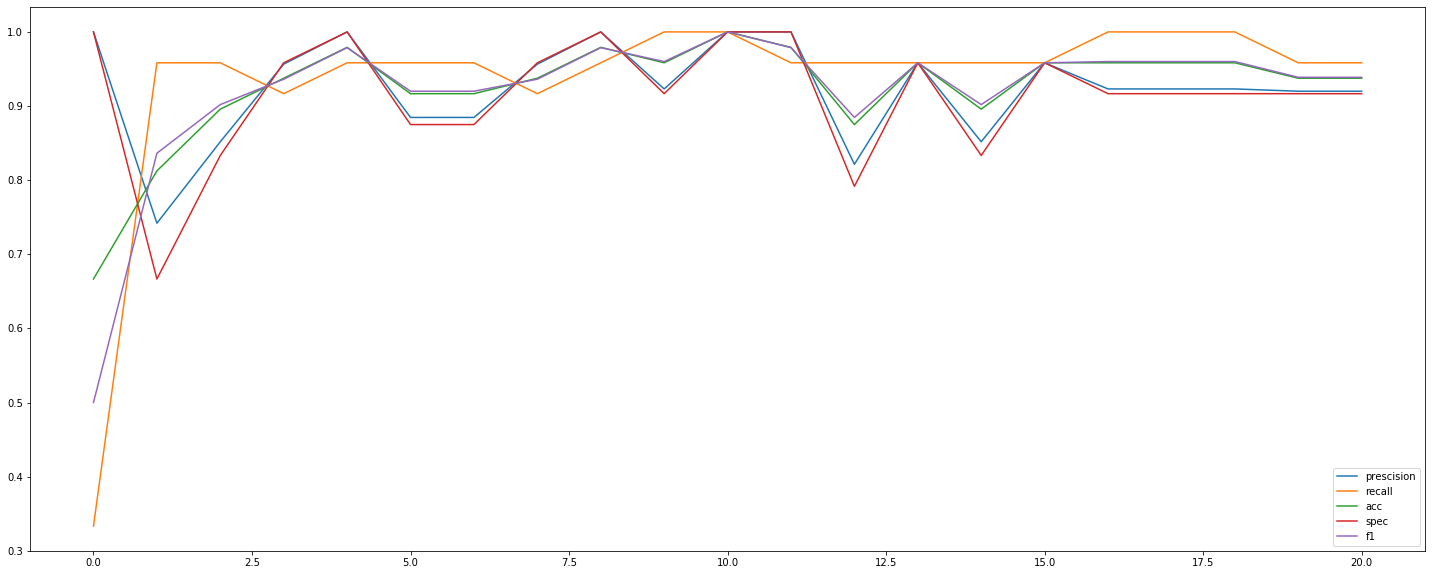

In [0]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [25, 10]
#x= range(10,1+int(348*args["num_train_epochs"]/args["train_batch_size"]),args["save_steps"])

plt.plot(p,label="prescision")
plt.plot(r,label="recall")
plt.plot(a,label="acc")
plt.plot(s,label="spec")
plt.plot(f,label="f1")
plt.legend()
plt.show()


In [0]:
!cp ./data/dev.tsv

##Predictions

In [0]:
checkpoints = [args['output_dir']]
if args['eval_all_checkpoints']:
    checkpoints = list(os.path.dirname(c) for c in sorted(glob.glob(args['output_dir'] + '/**/' + WEIGHTS_NAME, recursive=True)))
    logging.getLogger("pytorch_transformers.modeling_utils").setLevel(logging.WARN)  # Reduce logging
logger.info("Evaluate the following checkpoints: %s", checkpoints)
for checkpoint in checkpoints:
    global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
    model = model_class.from_pretrained(checkpoint)
    model.to(device)
    preds = predict(model, tokenizer, prefix=global_step)

In [0]:
print(preds)

In [0]:
for checkpoint in checkpoints:
  global_step = checkpoint.split('-')[-1] if len(checkpoints) > 1 else ""
  model = model_class.from_pretrained(checkpoint)
  model.to(device)
  result, wrong_preds = evaluate(model, tokenizer, prefix=global_step)
  result = dict((k + '_{}'.format(global_step), v) for k, v in result.items())
  results.update(result)


In [0]:
!gsutil -m cp -r ./outputs_roberta gs://qatar_competition/outputs_roberat_base_cased_english_10epochs/

Copying file://./outputs_roberta/merges.txt [Content-Type=text/plain]...
Copying file://./outputs_roberta/eval_results.txt [Content-Type=text/plain]...
Copying file://./outputs_roberta/config.json [Content-Type=application/json]...
Copying file://./outputs_roberta/vocab.json [Content-Type=application/json]...
Copying file://./outputs_roberta/pytorch_model.bin [Content-Type=application/octet-stream]...
Copying file://./outputs_roberta/added_tokens.json [Content-Type=application/json]...
Copying file://./outputs_roberta/checkpoint-480/config.json [Content-Type=application/json]...
Copying file://./outputs_roberta/special_tokens_map.json [Content-Type=application/json]...
Copying file://./outputs_roberta/tokenizer_config.json [Content-Type=application/json]...
Copying file://./outputs_roberta/training_args.bin [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This

In [0]:
!mv ./data/train.tsv ./data/temp.tsv
!mv ./data/dev.tsv ./data/train.tsv
!mv ./data/temp.tsv ./data/dev.tsv